> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-10, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        
        self.loss_diffusion_reg = 10*tf.math.exp(-self.D_a/1e-1) + 10*tf.math.exp(-self.D_s/1e-1)

        self.loss = self.loss_1 + self.loss_a + self.loss_s +  self.loss_diffusion_reg      

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, loss_dif, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()}, loss_diffusion: {loss_dif.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        arr_total_loss_diffusion_reg = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            total_loss_diffusion_reg = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                loss_a_value = _get_val(self.sess.run(self.loss_a, tf_dict))
                loss_s_value = _get_val(self.sess.run(self.loss_s, tf_dict))
                loss_diffusion_reg_value = _get_val(self.sess.run(self.loss_diffusion_reg, tf_dict))
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
                total_loss_diffusion_reg += loss_diffusion_reg_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss_diffusion  : {total_loss_diffusion_reg:.8f}\n"
                      f"loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss_diffusion  : {total_loss_diffusion_reg:.8f}\n"
                      f"loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_total_loss_diffusion_reg[it] = total_loss_diffusion_reg
                arr_D_a[it] = D_a_value
                arr_D_s[it] = D_s_value                
                arr_sigma_a[it] = sigma_a_value
                arr_sigma_s[it] = sigma_s_value
                arr_rho_a[it] = rho_a_value
                arr_rho_s[it] = rho_s_value
                arr_mu_a[it] = mu_a_value
                arr_kappa_a[it] = kappa_a_value                
                                
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], 
                        arr_total_loss_a[:(it+1)], 
                        arr_total_loss_s[:(it+1)], 
                        arr_total_loss_diffusion_reg[:(it+1)], 
                        params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            arr_total_loss_diffusion_reg[it] = total_loss_diffusion_reg
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
        # end for it
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, 
                arr_total_loss_a, 
                arr_total_loss_s, 
                arr_total_loss_diffusion_reg,
                params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s, self.loss_diffusion_reg,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s, loss_diffusion, params_estimates = \
model.train_batch(10000, batch_size=N*T//128, early_stop_thresh=10.0, print_iter=50)

It: 0, loss_a  : 657.65838759, loss_s  : 5117.96289638, loss_diffusion  : 0.10440534
loss  : 24351.28,
D_a: 0.99058419, D_s: 1.08843505
sigma_a: 0.08804464, sigma_s: 0.94516540
rho_a: 1.10578489, rho_s: 1.08768272
mu_a: 0.89638960, kappa_a: 0.89494228, 
Time:5.20

It: 50, loss_a  : 5.30860108, loss_s  : 7.13337966, loss_diffusion  : 0.00008989
loss  : 9906.32,
D_a: 1.80826950, D_s: 1.67331588
sigma_a: 0.07757513, sigma_s: 0.81969476
rho_a: 1.09878039, rho_s: 1.19905400
mu_a: 0.81861591, kappa_a: 0.85898554, 
Time:117.53

It: 100, loss_a  : 2.96688239, loss_s  : 4.78550524, loss_diffusion  : 0.00017356
loss  : 9901.12,
D_a: 1.57287252, D_s: 2.97159076
sigma_a: 0.02306286, sigma_s: 0.74345428
rho_a: 1.09178364, rho_s: 1.14147186
mu_a: 0.73098993, kappa_a: 0.95731544, 
Time:117.49

It: 150, loss_a  : 3.17212425, loss_s  : 3.68043874, loss_diffusion  : 0.00018636
loss  : 9902.45,
D_a: 1.56555498, D_s: 7.98151779
sigma_a: 0.00269929, sigma_s: 0.66715026
rho_a: 1.06506336, rho_s: 1.08118522


It: 1600, loss_a  : 3.29339383, loss_s  : 1.35741924, loss_diffusion  : 1.66771382
loss  : 12.34,
D_a: 0.68542469, D_s: 0.82723945
sigma_a: 0.00000000, sigma_s: 0.07756399
rho_a: 1.26990271, rho_s: 0.07738395
mu_a: 1.27398467, kappa_a: 0.24772537, 
Time:117.36

It: 1650, loss_a  : 4.32800788, loss_s  : 1.31239650, loss_diffusion  : 1.54654089
loss  : 18.10,
D_a: 0.69357091, D_s: 0.83073056
sigma_a: 0.00003338, sigma_s: 0.07773911
rho_a: 1.28743148, rho_s: 0.07786056
mu_a: 1.29029262, kappa_a: 0.24833725, 
Time:117.59

It: 1700, loss_a  : 3.55953157, loss_s  : 1.22950955, loss_diffusion  : 1.45262036
loss  : 13.33,
D_a: 0.70013833, D_s: 0.83674574
sigma_a: 0.00000000, sigma_s: 0.07862909
rho_a: 1.30249965, rho_s: 0.07879712
mu_a: 1.30583251, kappa_a: 0.24813293, 
Time:117.46

##################################################
         Early stop
##################################################
It: 1711, loss_a  : 2.84427094, loss_s  : 1.20352902, loss_diffusion  : 1.42491418
loss  : 9

In [ ]:
model.minimise(max_iter=100)  

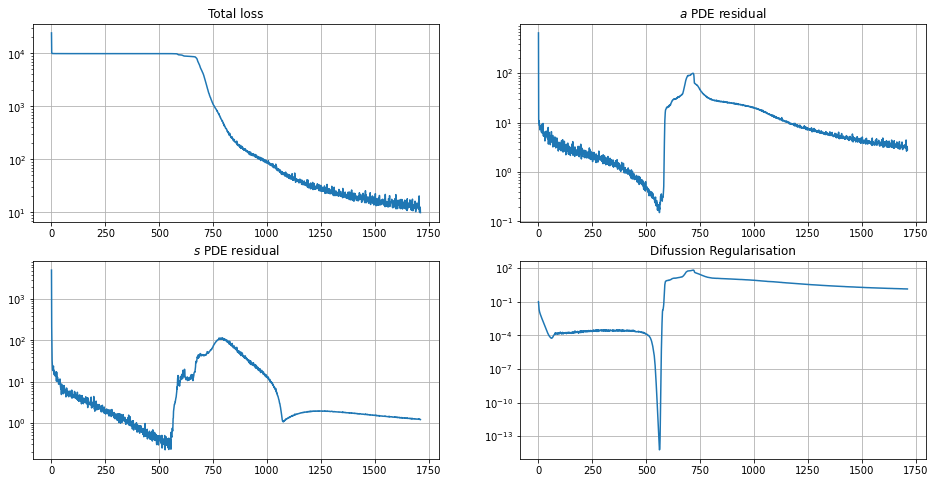

In [5]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()

plt.subplot(2,2,4)
plt.plot(loss_diffusion[start:end])
plt.yscale('log')
plt.title(r"Difussion Regularisation")
plt.grid()

plt.show()



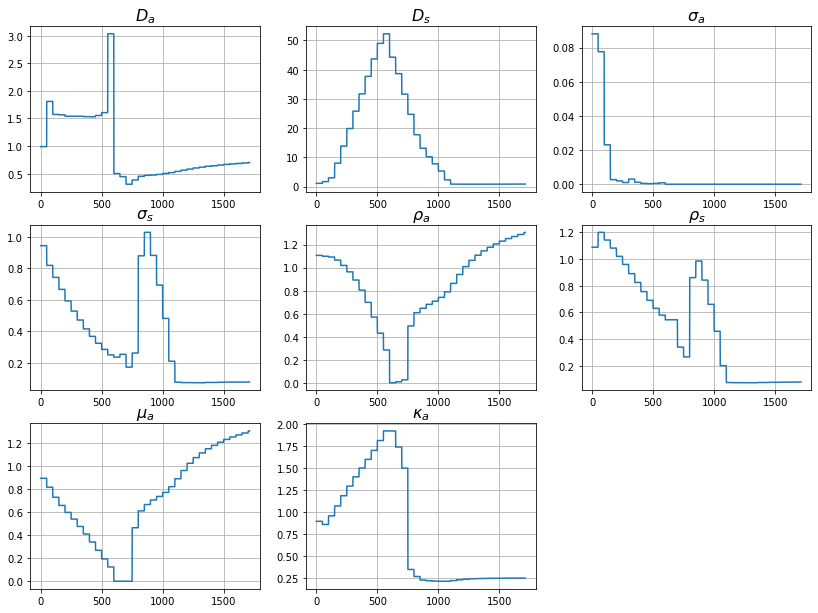

In [6]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates['D_a']])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates['D_s']])
plt.title(r"$D_s$", fontsize=16)
#plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates['sigma_a']])
plt.title(r"$\sigma_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates['rho_a']])
plt.title(r"$\rho_a$", fontsize=16)
#plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates['mu_a']])
plt.title(r"$\mu_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.show()

In [8]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

D_a = model.sess.run(model.D_a)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a = model.sess.run(model.sigma_a)
rho_a = model.sess.run(model.rho_a)
mu_a = model.sess.run(model.mu_a)
kappa_a = model.sess.run(model.kappa_a)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("D_a", D_a, 0.005)
print_vals("sigma_a", sigma_a, 0.0)
print_vals("rho_a", rho_a,0.01)
print_vals("mu_a", mu_a, 0.01 )
print_vals("kappa_a", kappa_a, 0.25)

D_s: 0.84104031, actual: 0.200, difference: 0.64104031, relative: %320.52015662
sigma_s: 0.07856113, actual: 0.020, difference: 0.05856113, relative: %292.80563593
rho_s: 0.07871228, actual: 0.020, difference: 0.05871228, relative: %293.56138557

D_a: 0.70243835, actual: 0.005, difference: 0.69743835, relative: %13948.76708984
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 1.30607688, actual: 0.010, difference: 1.29607688, relative: %12960.76884270
mu_a: 1.30879998, actual: 0.010, difference: 1.29879998, relative: %12987.99982071
kappa_a: 0.24789673, actual: 0.250, difference: 0.00210327, relative: %0.84130764


# Estimated parameters

In [133]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[-T:]#[50000]#t_star[-T:]#t_star[index]#0#5000000

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [134]:
t_2.shape

(32768, 1)

In [135]:
t_test

array([46966.73189824, 47064.57925636, 47162.42661448, 47260.2739726 ,
       47358.12133072, 47455.96868885, 47553.81604697, 47651.66340509,
       47749.51076321, 47847.35812133, 47945.20547945, 48043.05283757,
       48140.90019569, 48238.74755382, 48336.59491194, 48434.44227006,
       48532.28962818, 48630.1369863 , 48727.98434442, 48825.83170254,
       48923.67906067, 49021.52641879, 49119.37377691, 49217.22113503,
       49315.06849315, 49412.91585127, 49510.76320939, 49608.61056751,
       49706.45792564, 49804.30528376, 49902.15264188, 50000.        ])

In [136]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:a_train,
           model.s_tf:s_train}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_2 = model.sess.run(model.loss, tf_dict)

print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss   : {l_2:.8f}")
print( f"Loss Diff  : {l_2-l_a_2-l_s_2:.8f}")

Loss_a : 0.00000040
Loss_s : 0.00000159
Loss   : 9.95555687
Loss Diff  : 9.95555496


In [137]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

8.502239075754737
1.4533152356548327
9.95555431140957


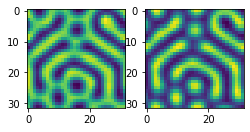

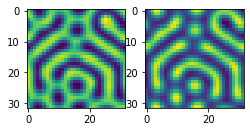

In [138]:
start = 0
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()



In [59]:
T

32

In [96]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = 500#-1
t_test = 25000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [97]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00000008
Loss_s : 0.00005015
Loss   : 48.38435745


In [98]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

44.568421832960176
3.815885208497169


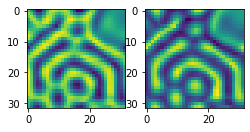

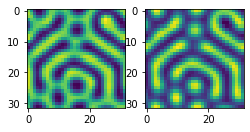

In [99]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [363]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_full_32_steps', global_step=0)

'./PINN_Turring_model_loss_full_32_steps-0'

In [364]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_19:0
y_tf_19:0
t_tf_19:0
a_pred_19:0
s_pred_19:0
add_253:0
loss_a_19:0
loss_s_19:0
